In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.inspection import (
    permutation_importance, PartialDependenceDisplay
)

from imblearn.over_sampling import RandomOverSampler
from scipy.stats import randint, uniform, reciprocal, expon


In [10]:
#General eval metrics
def evaluate_predictions(meta_df, probs, target):
    df = meta_df.copy()
    df[f'prob_{target}'] = probs

    df = df.sort_values(by=['year', 'event', 'GridPosition'])
    df[f'rank_{target}'] = df.groupby('event')[f'prob_{target}'].rank(ascending=False, method='first')

    first_place_acc = (df[df["Position"] == 1][f'rank_{target}'] == 1).mean()
    df['is_podium_actual'] = df["Position"].isin([1, 2, 3])
    df['is_podium_predicted'] = df[f'rank_{target}'] <= 3
    podium_acc = (df['is_podium_actual'] == df['is_podium_predicted']).mean()
    total_rank_acc = (df["Position"] == df[f'rank_{target}']).mean()

    print(f"\nEvaluation - Target: {target}")
    print("First place accuracy:", round(first_place_acc, 4))
    print("Podium accuracy:", round(podium_acc, 4))
    print("Exact position accuracy:", round(total_rank_acc, 4))

    return df


In [11]:
#Permutation Importance (mandatory)
def plot_permutation_importance(model, X_test, y_test, feature_names, target):
    print("\nComputing permutation importance...")
    result = permutation_importance(
        model, X_test, y_test, n_repeats=20, random_state=42, scoring="roc_auc"
    )

    sorted_idx = result.importances_mean.argsort()[::-1][:20]
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], result.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"Permutation Importance – {target}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [12]:
#PDP (mandatory)
def plot_top_pdp(model, X, feature_names, top_n=6):
    print(f"\n Partial Dependence on Top {top_n} Features:")
    
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    
    top_features = []
    for idx in sorted_idx:
        fname = feature_names[idx]
        if fname in X.columns and X[fname].nunique() > 5 and not fname.startswith(('event_', 'FullName_', 'TeamFamily_')):
            top_features.append(fname)
        if len(top_features) >= top_n:
            break
    print("Selected features:", top_features)

    fig, ax = plt.subplots(figsize=(12, 5 * len(top_features))) #Adjust size pls
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=top_features,
        feature_names=feature_names,
        grid_resolution=20,
        kind="average",
        ax=ax
    )
    plt.tight_layout()
    plt.show()


In [ ]:
def run_xgb(df_path, target, param_search=True):
    df = pd.read_csv(df_path)

    # Targets
    df["is_winner"] = (df["Position"] == 1).astype(int)
    df["is_podium"] = df["Position"].isin([1, 2, 3]).astype(int)

    # Meta
    meta = df[["FullName", "event", "year", "TeamFamily", "GridPosition", "Position"]].copy()

    # Features
    df = df.drop(columns=["year", "Position"])
    df = pd.get_dummies(df, columns=["event", "TeamFamily", "FullName"], drop_first=False)

    y = df[target]
    X = df.drop(columns=["is_winner", "is_podium"])
    feature_names = X.columns

    train_mask = meta["year"] <= 2022
    valid_mask = meta["year"] == 2023 # useless? (since RandomizedSearchCV)
    test_mask = meta["year"] == 2024

    X_train, y_train = X[train_mask], y[train_mask]
    X_valid, y_valid = X[valid_mask], y[valid_mask] # useless? (since RandomizedSearchCV)
    X_test, y_test = X[test_mask], y[test_mask]
    meta_test = meta[test_mask].reset_index(drop=True)

    # Oversample training (Big disbalance (5% vs 95% for winner and 15% vs 85% for podium)
    over = RandomOverSampler(random_state=42)
    X_os, y_os = over.fit_resample(X_train, y_train)

    if param_search:
        param_dist = {
            "n_estimators": randint(100, 500),
            "max_depth": randint(3, 8),
            "learning_rate": reciprocal(0.01, 0.2),
            "subsample": uniform(0.5, 0.5),
            "colsample_bytree": uniform(0.5, 0.5),
            "reg_alpha": expon(scale=1),
            "reg_lambda": uniform(0, 3)
        }
        # Also maybe Time series cross validation if time.
        search = RandomizedSearchCV(
            estimator=XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False),
            param_distributions=param_dist,
            n_iter=200,
            scoring="neg_log_loss", #Binary Cross Entropy (cause Binary Target)
            cv=5,
            verbose=1,
            n_jobs=-1
        )
        search.fit(X_os, y_os)
        model = search.best_estimator_
        print(model)
    else:
        model = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss", #Binary Cross Entropy (cause Binary Target)
            use_label_encoder=False,
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )
        model.fit(X_os, y_os)

    # Retrain on full past data
    X_full = pd.concat([X_train, X_valid])
    y_full = pd.concat([y_train, y_valid])
    X_full_os, y_full_os = over.fit_resample(X_full, y_full)
    model.fit(X_full_os, y_full_os)

    # Predict and evaluate
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    # More Metrics
    print("\n--- Test Metrics---")
    print("Log loss:", round(log_loss(y_test, probs), 4))
    print("AUC:", round(roc_auc_score(y_test, probs), 4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    print("\nClassification:")
    print(classification_report(y_test, preds, digits=4))

    # Ranking-based metrics
    results = evaluate_predictions(meta_test, probs, target)

    # Permutation importance
    plot_permutation_importance(model, X_test, y_test, feature_names, target)
    plot_top_pdp(model, X, feature_names, top_n=6)
    return model, results


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\apidb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [05:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\apidb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [05:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Test Metrics---
Log loss: 0.3354
AUC: 0.9323
Confusion Matrix:
[[331  76]
 [  6  66]]

Classification:
              precision    recall  f1-score   support

           0     0.9822    0.8133    0.8898       407
           1     0.4648    0.9167    0.6168        72

    accuracy                         0.8288       479
   macro avg     0.7235    0.8650    0.7533       479
weighted avg     0.9044    0.8288    0.8488       479


Evaluation - Target: is_podium
First place accuracy: 0.4583
Podium accuracy: 0.8873
Exact position accuracy: 0.1315

Computing permutation importance...


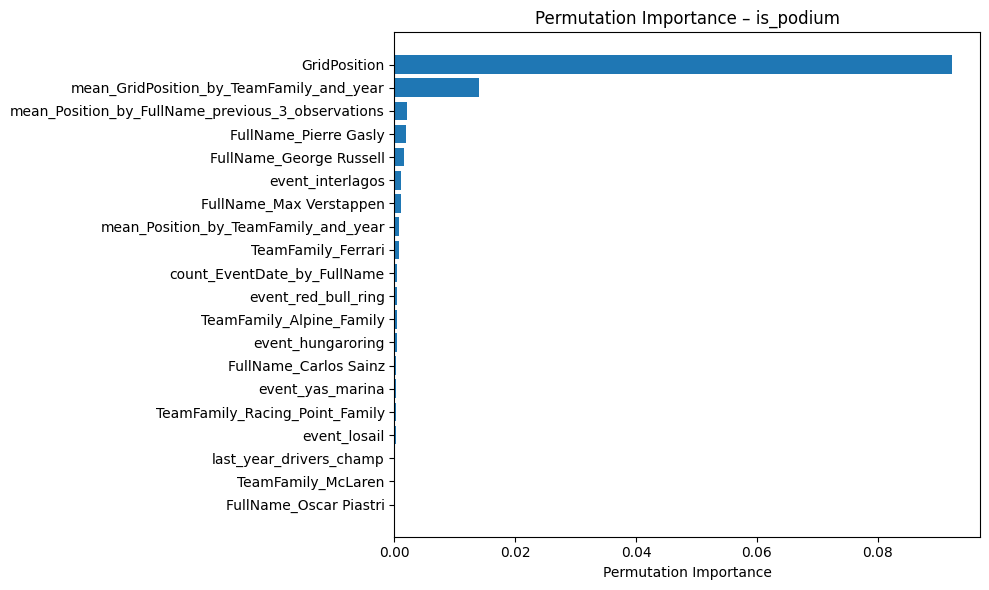


 Partial Dependence on Top 6 Features:
Selected features: ['GridPosition', 'mean_GridPosition_by_TeamFamily_and_year', 'mean_Position_by_TeamFamily_and_year', 'mean_GridPosition_by_TeamFamily_previous_3_observations', 'mean_Position_by_FullName_previous_3_observations', 'mean_GridPosition_by_FullName_previous_3_observations']


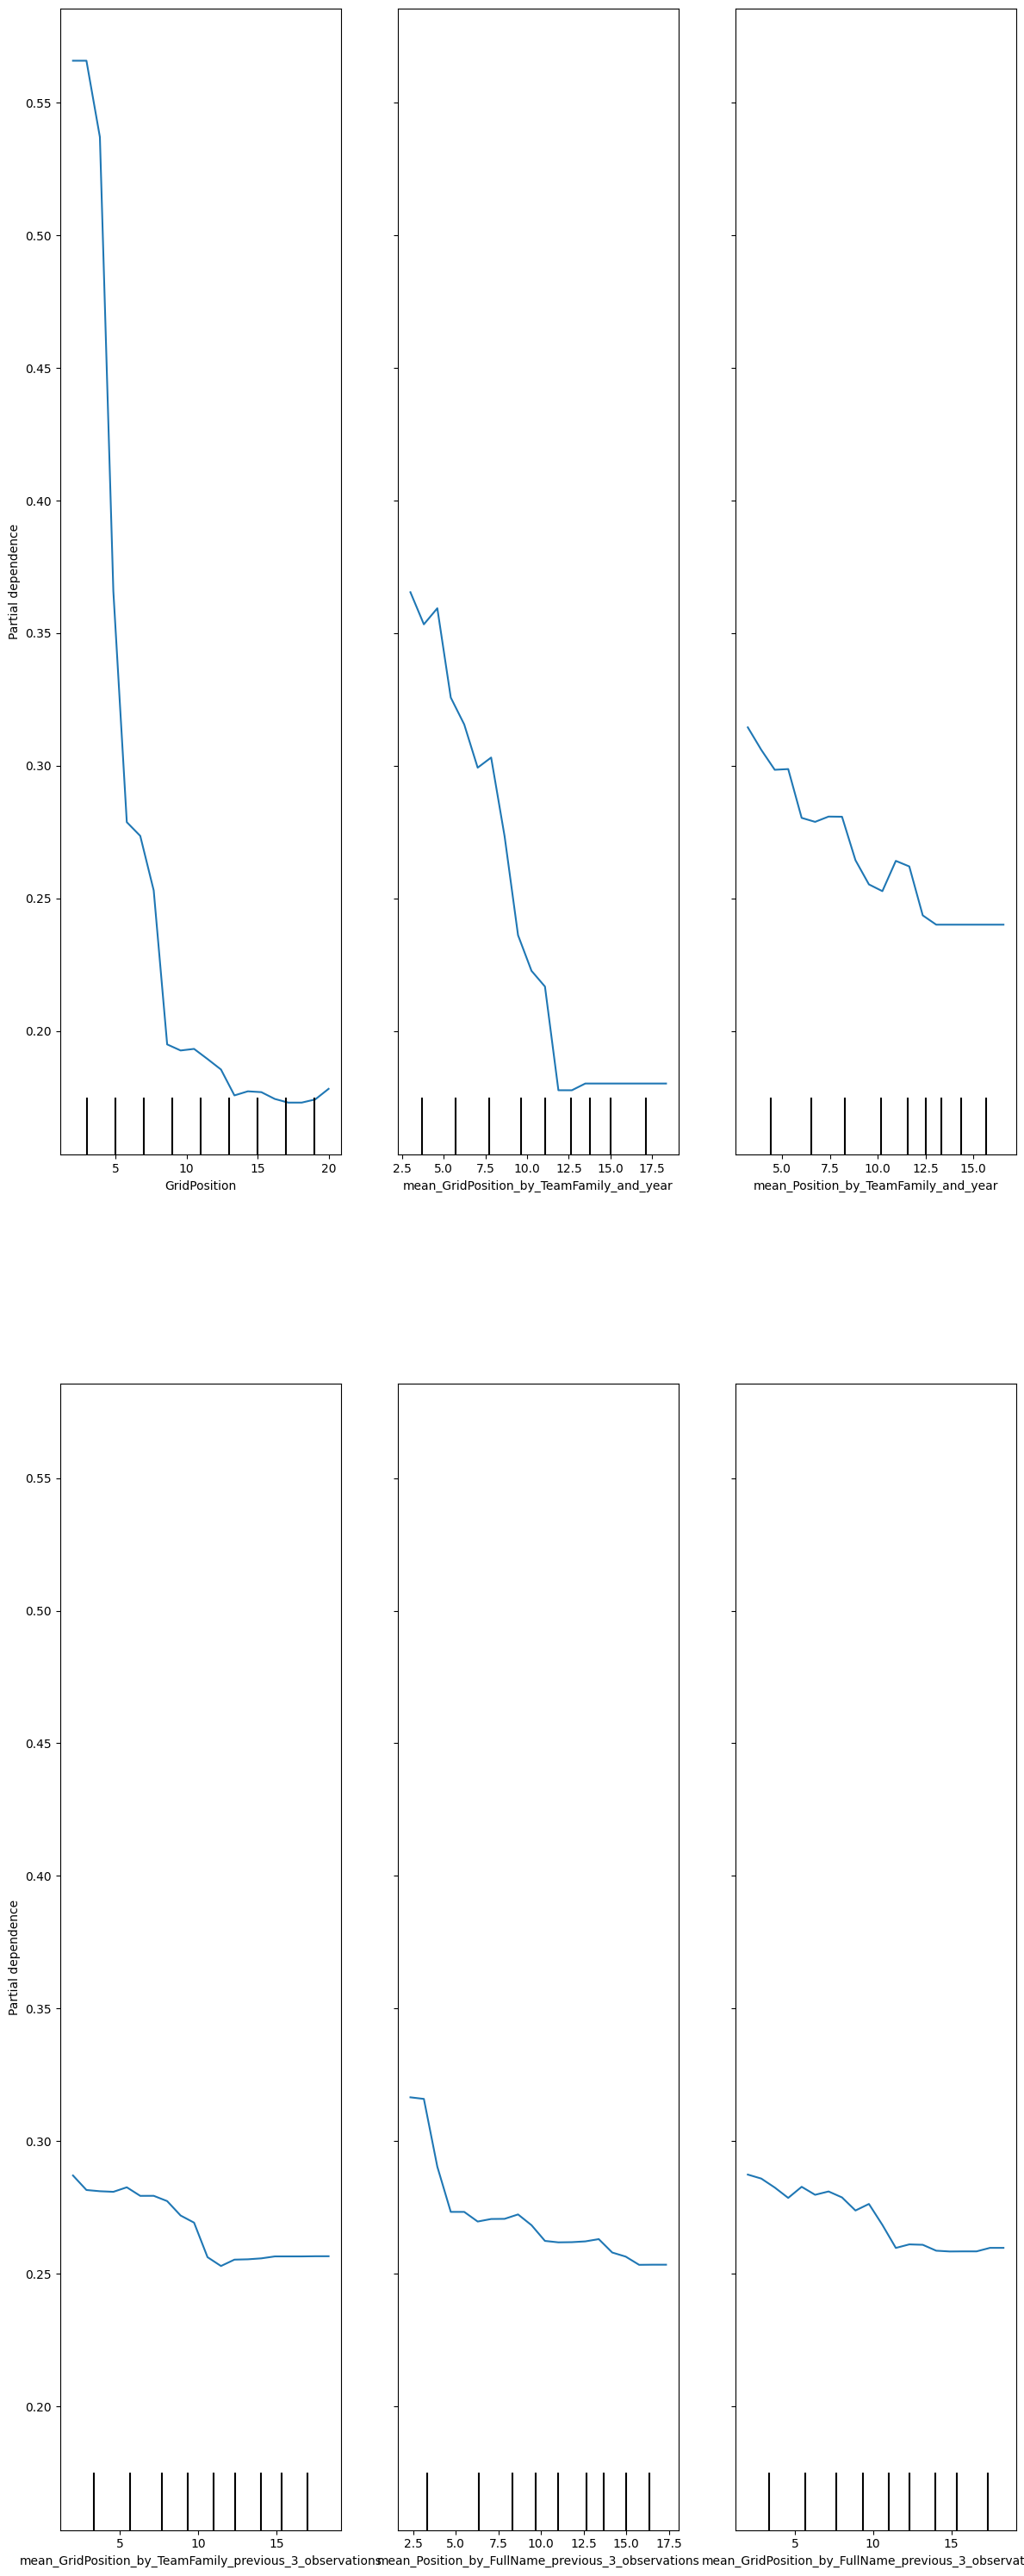

In [ ]:
model_podium, results_podium = run_xgb(
    df_path="Data/race_feature_2015_2024.csv",
    target="is_podium",
    param_search=True
)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\apidb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [05:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\apidb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [05:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Test Metrics---
Log loss: 0.1876
AUC: 0.9373
Confusion Matrix:
[[424  31]
 [  7  17]]

Classification:
              precision    recall  f1-score   support

           0     0.9838    0.9319    0.9571       455
           1     0.3542    0.7083    0.4722        24

    accuracy                         0.9207       479
   macro avg     0.6690    0.8201    0.7147       479
weighted avg     0.9522    0.9207    0.9328       479


Evaluation - Target: is_winner
First place accuracy: 0.4583
Podium accuracy: 0.8956
Exact position accuracy: 0.1566

Computing permutation importance...


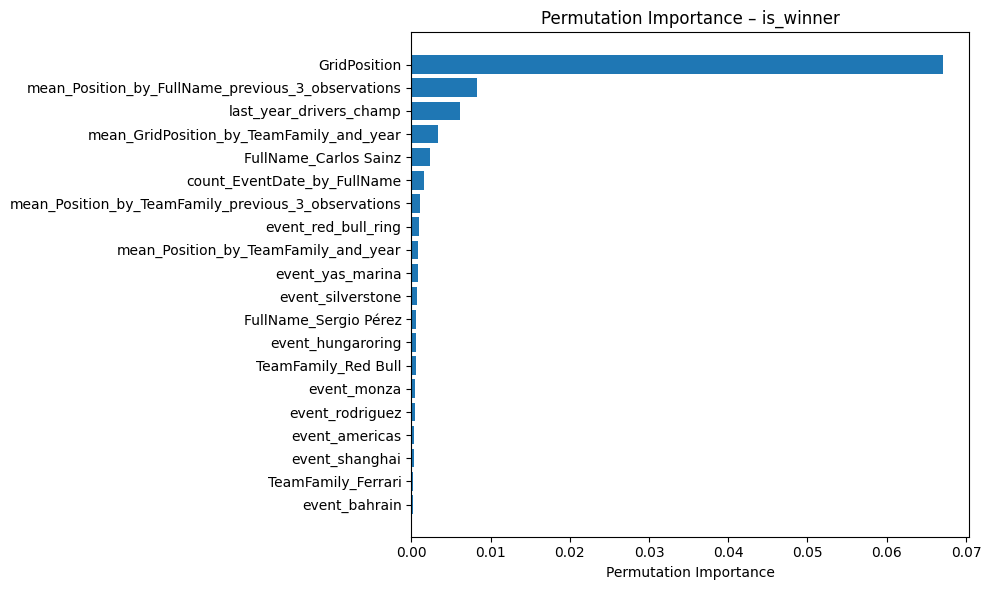


 Partial Dependence on Top 6 Features:
Selected features: ['GridPosition', 'mean_GridPosition_by_TeamFamily_and_year', 'mean_GridPosition_by_TeamFamily_previous_3_observations', 'mean_Position_by_TeamFamily_and_year', 'mean_GridPosition_by_FullName_previous_3_observations', 'mean_Position_by_TeamFamily_previous_3_observations']


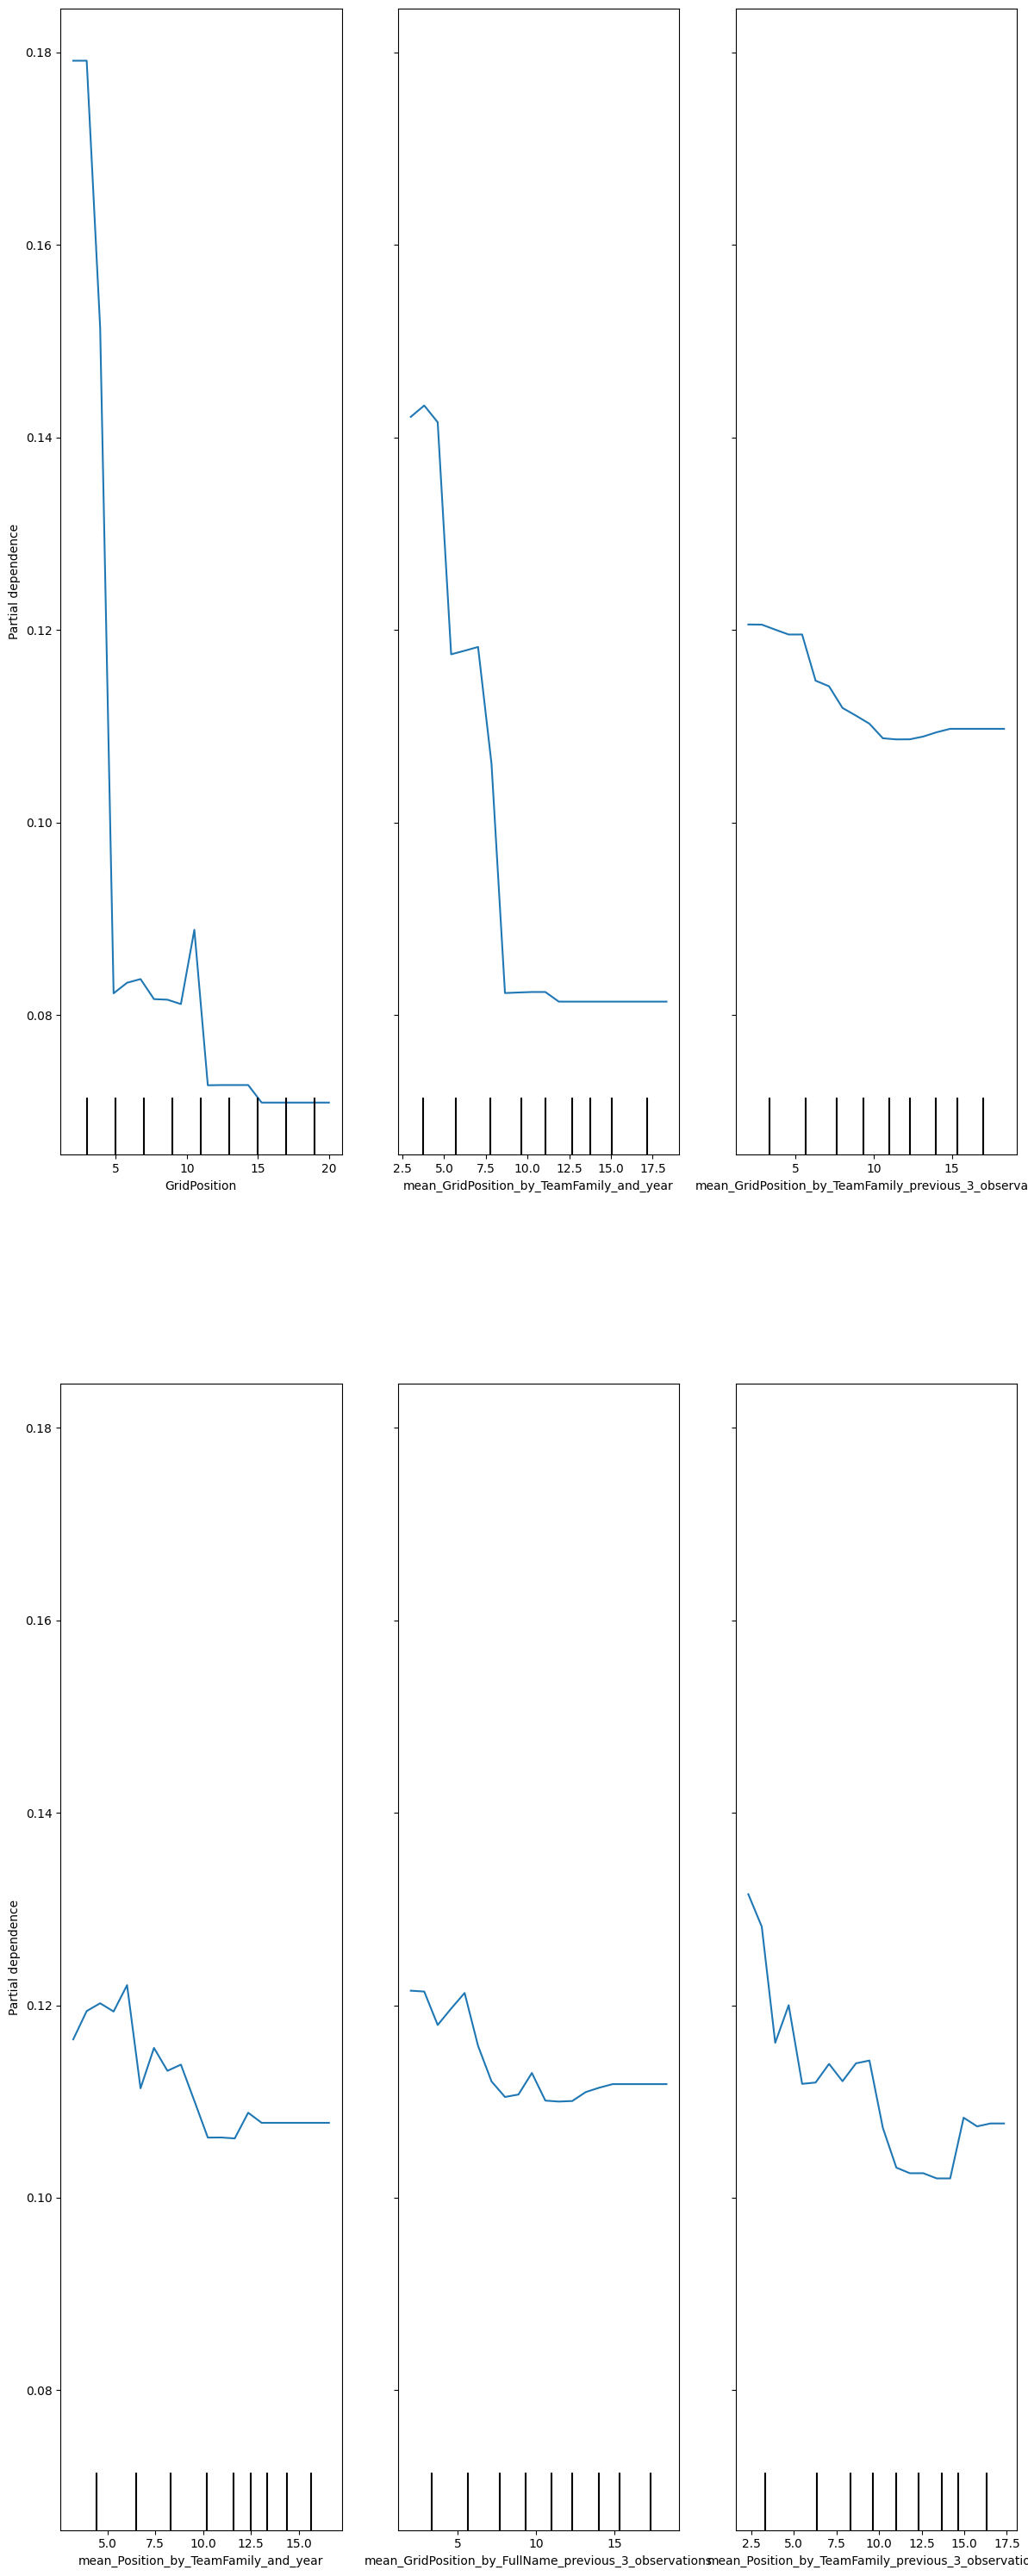

In [ ]:
model_winner, results_winner = run_xgb(
    df_path="Data/race_feature_2015_2024.csv",
    target="is_winner",
    param_search=True
)

(479, 10)

In [31]:
results_podium

,FullName,event,year,TeamFamily,GridPosition,Position,prob_is_podium,rank_is_podium,is_podium_actual,is_podium_predicted
310,Max Verstappen,albert_park,2024,Red Bull,1,19,0.921286,1.0,False,True
25,Carlos Sainz,albert_park,2024,Ferrari,2,1,0.804617,4.0,True,False
242,Lando Norris,albert_park,2024,McLaren,3,3,0.860532,2.0,True,True
49,Charles Leclerc,albert_park,2024,Ferrari,4,2,0.691263,5.0,True,False
361,Oscar Piastri,albert_park,2024,McLaren,5,4,0.560742,6.0,False,False
...,...,...,...,...,...,...,...,...,...,...
445,Valtteri Bottas,zandvoort,2024,Alfa_Romeo_Family,16,19,0.046239,15.0,False,False
183,Guanyu Zhou,zandvoort,2024,Alfa_Romeo_Family,17,20,0.044695,18.0,False,False
307,Logan Sargeant,zandvoort,2024,Williams,18,16,0.044060,19.0,False,False
14,Alexander Albon,zandvoort,2024,Williams,19,14,0.045358,17.0,False,False


In [33]:
results_winner[results_winner["FullName"] == "George Russell"]

,FullName,event,year,TeamFamily,GridPosition,Position,prob_is_winner,rank_is_winner,is_podium_actual,is_podium_predicted
147,George Russell,albert_park,2024,Mercedes,7,17,0.082408,7.0,False,False
163,George Russell,americas,2024,Mercedes,20,6,0.074539,6.0,False,False
145,George Russell,bahrain,2024,Mercedes,3,5,0.036315,5.0,False,False
161,George Russell,baku,2024,Mercedes,5,3,0.059496,7.0,True,False
154,George Russell,catalunya,2024,Mercedes,4,4,0.049501,7.0,False,False
157,George Russell,hungaroring,2024,Mercedes,17,8,0.099278,6.0,False,False
151,George Russell,imola,2024,Mercedes,6,7,0.042644,7.0,False,False
165,George Russell,interlagos,2024,Mercedes,2,4,0.335190,3.0,False,True
146,George Russell,jeddah,2024,Mercedes,7,6,0.128071,4.0,False,False
167,George Russell,losail,2024,Mercedes,1,4,0.732698,2.0,False,True


In [48]:
results_winner[results_winner["rank_is_winner"] == 1]

,FullName,event,year,TeamFamily,GridPosition,Position,prob_is_winner,rank_is_winner,is_podium_actual,is_podium_predicted
310,Max Verstappen,albert_park,2024,Red Bull,1,19,0.825552,1.0,False,True
258,Lando Norris,americas,2024,McLaren,1,4,0.892645,1.0,False,True
308,Max Verstappen,bahrain,2024,Red Bull,1,1,0.774456,1.0,True,True
324,Max Verstappen,baku,2024,Red Bull,6,5,0.825477,1.0,False,True
317,Max Verstappen,catalunya,2024,Red Bull,2,1,0.914314,1.0,True,True
320,Max Verstappen,hungaroring,2024,Red Bull,3,5,0.918111,1.0,False,True
314,Max Verstappen,imola,2024,Red Bull,1,1,0.918925,1.0,True,True
260,Lando Norris,interlagos,2024,McLaren,1,6,0.914865,1.0,False,True
309,Max Verstappen,jeddah,2024,Red Bull,1,1,0.817351,1.0,True,True
330,Max Verstappen,losail,2024,Red Bull,2,1,0.900505,1.0,True,True


In [49]:
results_winner[(results_winner["rank_is_winner"] == 1) & (results_winner["Position"] == 1)]

,FullName,event,year,TeamFamily,GridPosition,Position,prob_is_winner,rank_is_winner,is_podium_actual,is_podium_predicted
308,Max Verstappen,bahrain,2024,Red Bull,1,1,0.774456,1.0,True,True
317,Max Verstappen,catalunya,2024,Red Bull,2,1,0.914314,1.0,True,True
314,Max Verstappen,imola,2024,Red Bull,1,1,0.918925,1.0,True,True
309,Max Verstappen,jeddah,2024,Red Bull,1,1,0.817351,1.0,True,True
330,Max Verstappen,losail,2024,Red Bull,2,1,0.900505,1.0,True,True
257,Lando Norris,marina_bay,2024,McLaren,1,1,0.894537,1.0,True,True
312,Max Verstappen,shanghai,2024,Red Bull,1,1,0.927091,1.0,True,True
311,Max Verstappen,suzuka,2024,Red Bull,1,1,0.917449,1.0,True,True
316,Max Verstappen,villeneuve,2024,Red Bull,2,1,0.928463,1.0,True,True
263,Lando Norris,yas_marina,2024,McLaren,1,1,0.902991,1.0,True,True


In [30]:
results_winner.to_excel("C:/Users/apidb/OneDrive/Bureau/Lagg/XGBOOSTwinner.xlsx")
results_podium.to_excel("C:/Users/apidb/OneDrive/Bureau/Lagg/XGBOOSTpodium.xlsx")